In [1]:
!pip install sentencepiece
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
from torch.utils.data import DataLoader
import sentencepiece as spm
from dataset import TinyStoriesDataset
from train import *
from model import *
import torch
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
with open("jsons/data00.json") as f:
    string = f.readline()
d = json.loads(string)
d[0]


{'story': '\n\nLily and Ben are friends. They like to play in the park. One day, they see a big tree with a swing. Lily wants to try the swing. She runs to the tree and climbs on the swing.\n"Push me, Ben!" she says. Ben pushes her gently. Lily feels happy. She swings higher and higher. She laughs and shouts.\nBen watches Lily. He thinks she is cute. He wants to swing too. He waits for Lily to stop. But Lily does not stop. She swings faster and faster. She is having too much fun.\n"Can I swing too, Lily?" Ben asks. Lily does not hear him. She is too busy swinging. Ben feels sad. He walks away.\nLily swings so high that she loses her grip. She falls off the swing. She lands on the ground. She hurts her foot. She cries.\n"Ow, ow, ow!" she says. She looks for Ben. She wants him to help her. But Ben is not there. He is gone.\nLily feels sorry. She wishes she had shared the swing with Ben. She wishes he was there to hug her. She limps to the tree. She sees something hanging from a branch. I

In [19]:
dataset_size = 100
with open("jsons/data00.json", "r") as g:
    js = json.loads(g.readline())
    with open("small_dataset", 'w+') as f:
        for i in range(dataset_size):
            f.write(js[i]["story"])

spm.SentencePieceTrainer.train(
    input="small_dataset",
    model_prefix='small_dataset',
    model_type='bpe',
    vocab_size=1000,
    normalization_rule_name='identity',
    pad_id=0, eos_id=1, bos_id=2, unk_id=3
)
tokenizer = spm.SentencePieceProcessor(model_file="small_dataset.model")


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: small_dataset
  input_format: 
  model_prefix: small_dataset
  model_type: BPE
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 2
  eos_id: 1
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential_privacy_clip

In [20]:
small_dataset = TinyStoriesDataset(["jsons/data00.json"], tokenizer, dataset_size=dataset_size)


100%|██████████| 100/100 [00:00<00:00, 1035.29it/s]


In [11]:
import torch
import numpy as np
from tqdm import tqdm
# l = ["Lily and Ben are friends.", "They like to play in the park"]
# seqs = [torch.tensor(tokenizer.encode(x, add_eos=True, add_bos=True), dtype=torch.int) for x in l]
# seqs
ls = []
s = []
for i in tqdm(range(len(small_dataset))):
    ls.append(len(tokenizer.encode(small_dataset[i], add_eos=True, add_bos=True)))
    s.append(len(small_dataset[i]))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1313.16it/s]


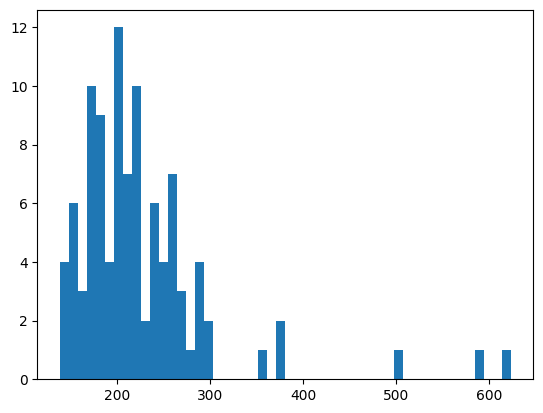

In [12]:
plt.hist(ls, bins=50)
plt.show()

In [13]:
print(np.quantile(ls, 0.999))

619.7329999999998


In [16]:
# device = torch.device("cuda:0")

In [21]:
decoder = BoutiqueLM(
    vocab_stories_size=1000,
    num_layers=1,
    num_heads=8,
    hidden_dim=128,
    activation=nn.GELU,
    max_len=10000
)

In [22]:
sum(p.numel() for p in decoder.parameters())

453760

In [23]:
num_workers = 2
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer=optimizer, factor=1., total_iters=1)
train_loader = DataLoader(
    small_dataset,
    batch_size=100,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    small_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers
)

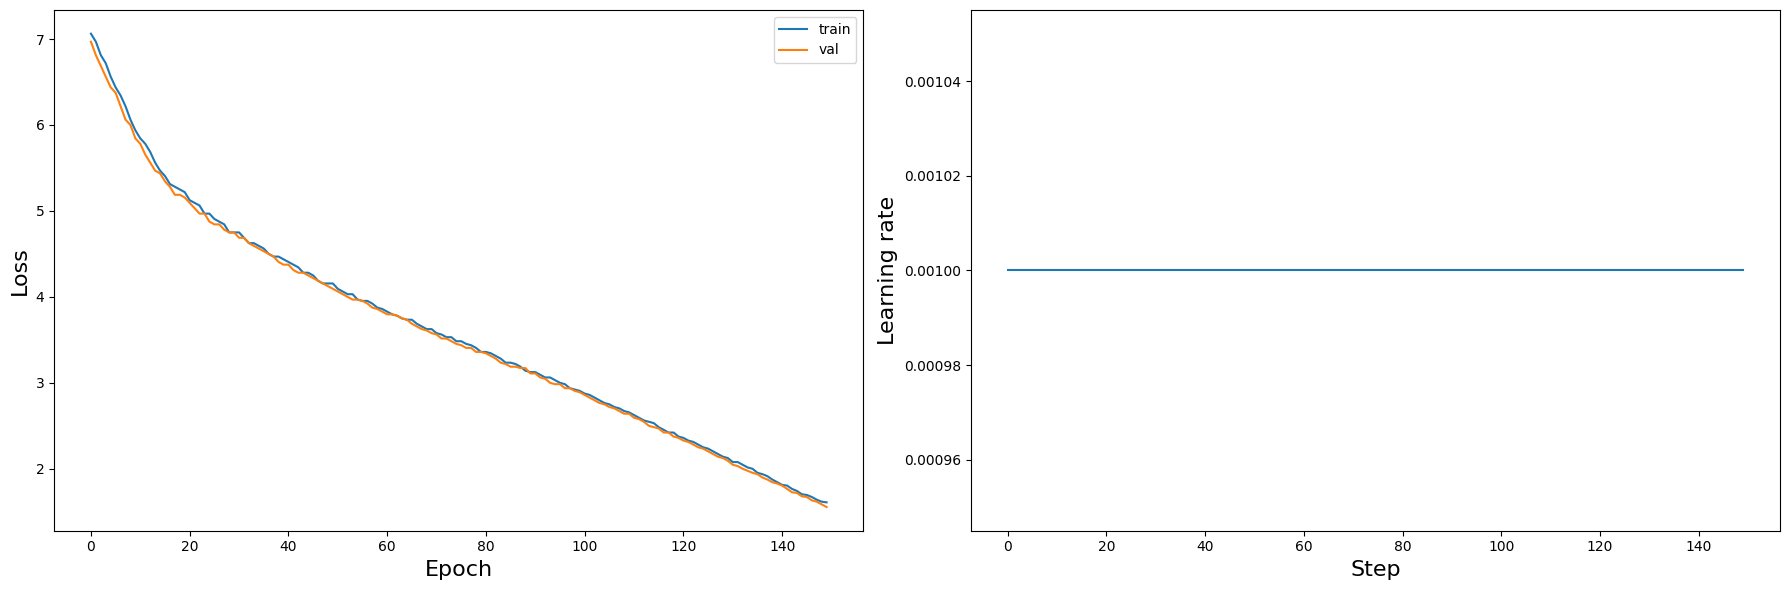

In [24]:
train(
    model=decoder,
    num_epochs=150,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    # device=torch.device("cuda:0")
)